In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [44]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plant village",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 0 2 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 2 1 1 0 1 1 1 1 0 2 2 1 1]


2024-07-01 16:03:05.542700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


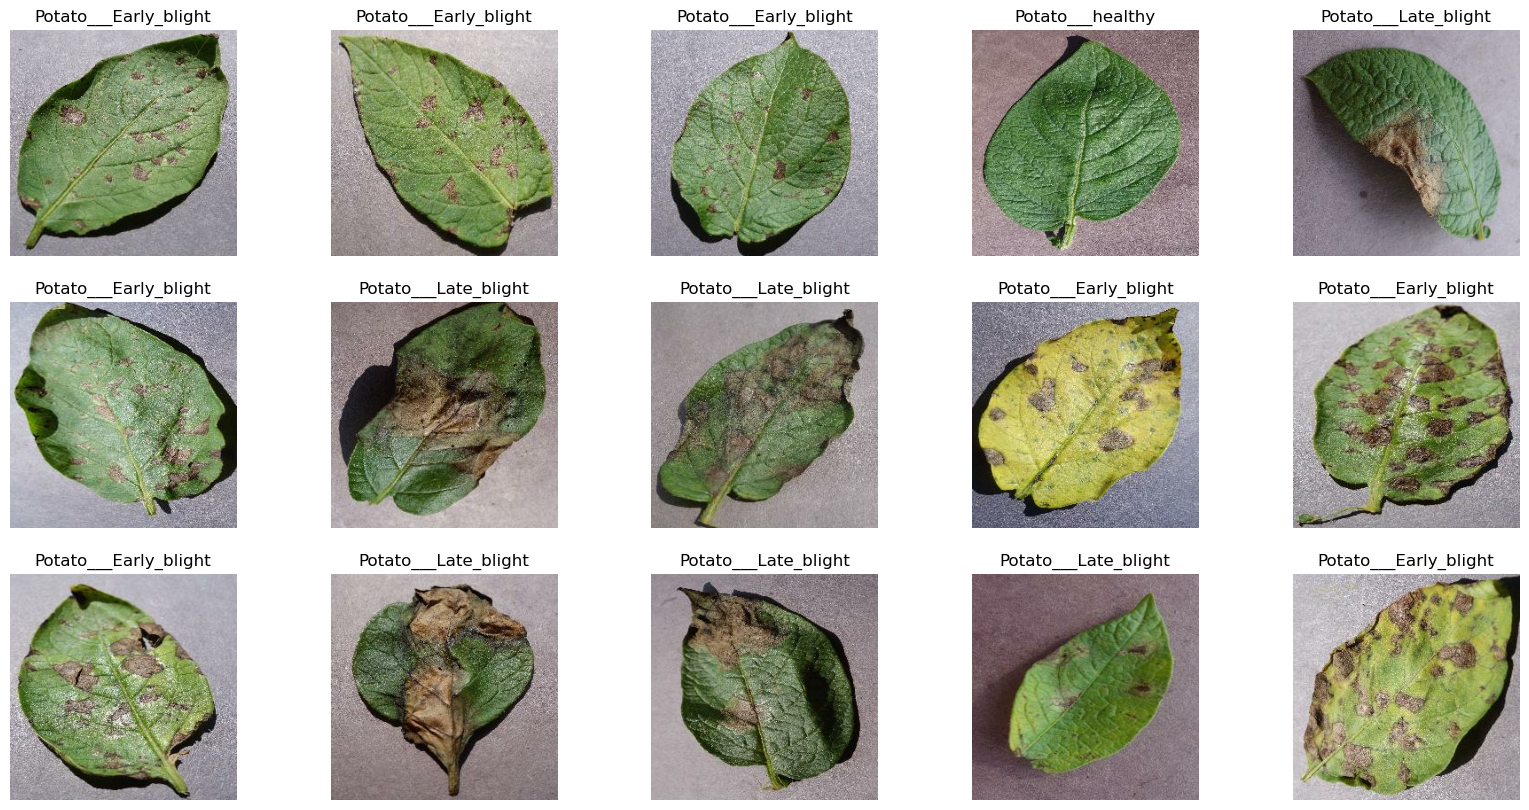

In [10]:
plt.figure(figsize=(20,10))

for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [11]:
len(dataset)

68

In [14]:
# 80% ==> training
# 20% ==> 10% validation and 10% test

In [17]:
#80% of the dataset
train_size = 0.8
len(dataset)*train_size

test_val_size = 0.1 # for test and validation
len(dataset)*test_val_size

6.800000000000001

In [19]:
# # since the dataset size we have to train is 54 

# train_ds = dataset.take(54)
# test_ds = dataset.skip(54) # this skip will read all the data except the first 54 samples.
# val_ds = test_ds.take(6)
# test_ds = test_ds.skip(6)

In [30]:
def dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [31]:
train_ds,val_ds,test_ds = dataset_partitions_tf(dataset)

In [32]:
print(len(train_ds),len(test_ds),len(val_ds))

54 8 6


In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [53]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])
resize_and_rescale

<Sequential name=sequential_7, built=False>

In [54]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [59]:
n_classes = 3
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(2,2),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [60]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (32, 255, 255, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (32, 126, 126, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (32, 63, 63, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (32, 62, 62, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (32, 31, 31, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (32, 30, 30, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (32, 15, 15, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (32, 14, 14, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (32, 7, 7, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (32, 6, 6, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (32, 3, 3, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 2, 2, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,267 (372.14 KB)

 Trainable params: 95,267 (372.14 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [62]:
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4615 - loss: 0.9505 - val_accuracy: 0.5312 - val_loss: 0.8507
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6228 - loss: 0.7625 - val_accuracy: 0.7708 - val_loss: 0.5799
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7926 - loss: 0.5199 - val_accuracy: 0.7760 - val_loss: 0.5292
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8536 - loss: 0.3867 - val_accuracy: 0.8385 - val_loss: 0.4566
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8709 - loss: 0.3711 - val_accuracy: 0.6979 - val_loss: 0.8768
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8623 - loss: 0.3384 - val_accuracy: 0.6771 - val_loss: 0.9398
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8926 - loss: 0.2953 - val_accuracy: 0.8750 - val_loss: 0.3216
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9334 - loss: 0.1872 - val_accuracy: 0.8698 - val_loss:

In [64]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.9447 - loss: 0.1783


In [65]:
scores

[0.16132852435112, 0.9453125]

In [66]:
history

In [67]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [68]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

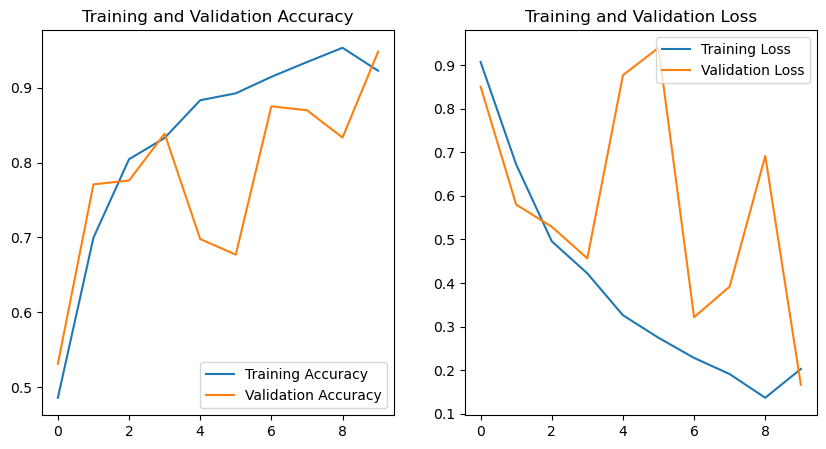

In [86]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(10),acc,label='Training Accuracy')
plt.plot(range(10),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(10),loss,label='Training Loss')
plt.plot(range(10),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


2024-07-02 10:23:56.736277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


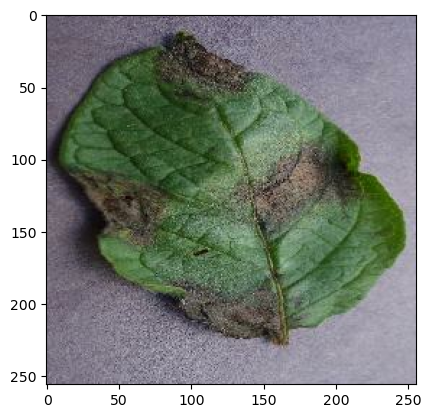

In [94]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    # plt.imshow(images_batch[0].numpy().astype('uint8'))
    # print(class_names[labels_batch[0].numpy()])
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    batch_prediction = model.predict(images_batch)
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [95]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2024-07-02 10:50:38.638356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


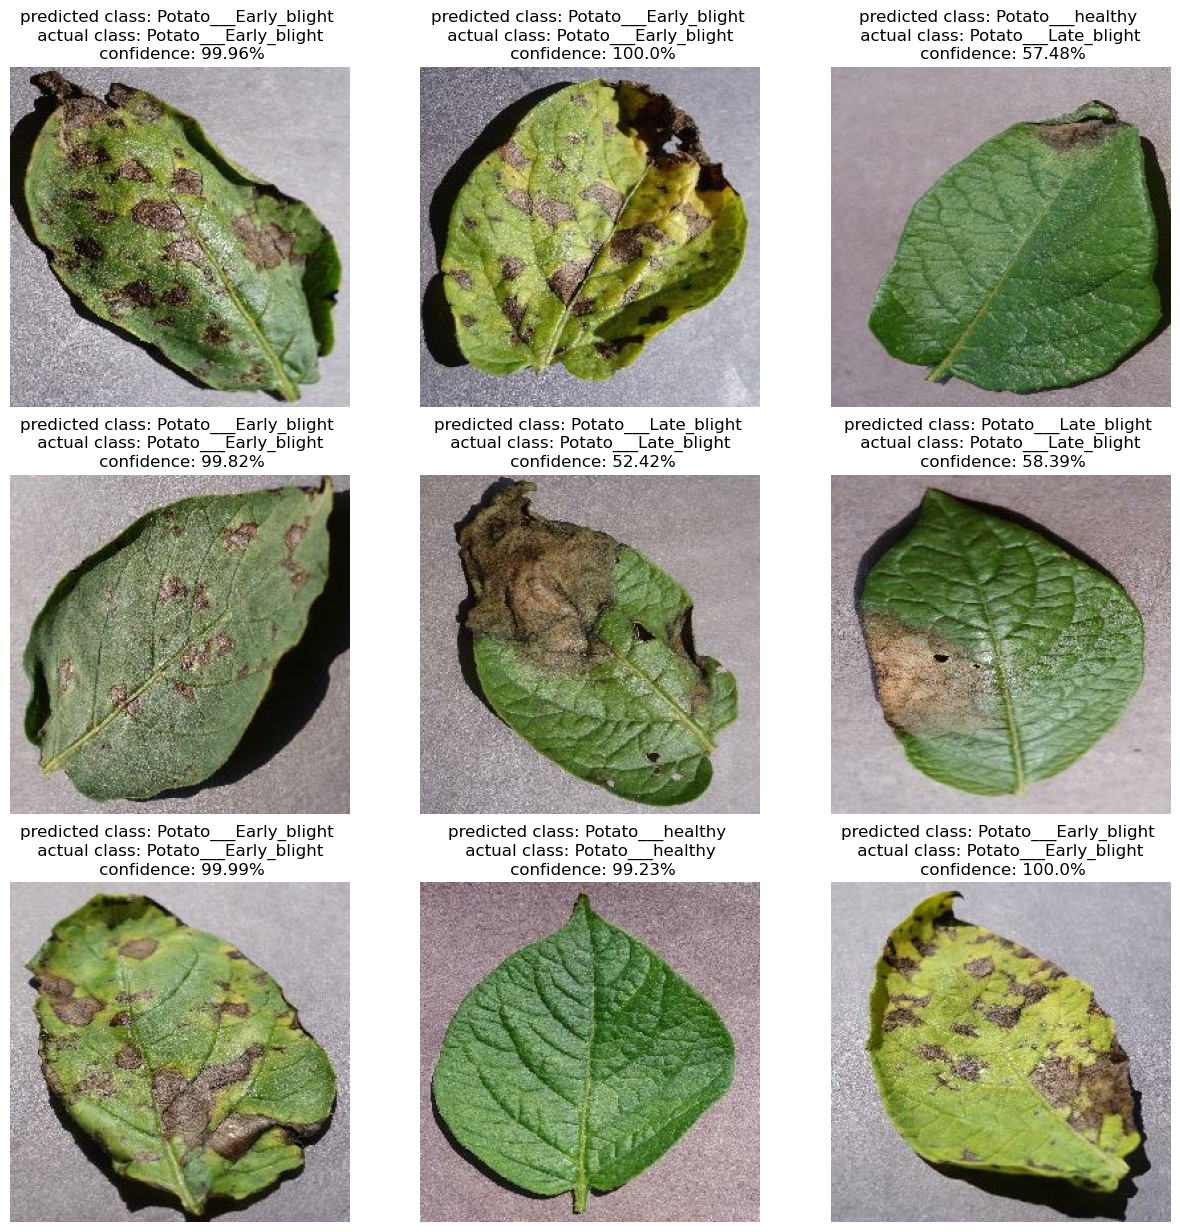

In [129]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        pred_class,confidence = predict(model,images[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'predicted class: {pred_class} \n actual class: {class_names[labels[i]]} \n confidence: {confidence}%')
        plt.axis('off')

In [135]:
model_version='version_2_model'
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/version_2_model/assets


INFO:tensorflow:Assets written to: ../models/version_2_model/assets


Saved artifact at '../models/version_2_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_52')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  10907568432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907568784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907578640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907579872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907578992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907580224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907579696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907580576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907580048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907580928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10907580400: TensorSpec(shape=(), dtype=tf

In [136]:
import os
os.listdir("../models")

['version_1_model', '.DS_Store', 'version_2_model']